<a href="https://colab.research.google.com/github/saigokhale/Social-Bias-in-ER/blob/Peeyush-S-Implementation-Logic/expw_v4_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps
1. Libraries
2. Dataset - read | create | show example
3. Dataloader - show example
4. Transforms - Normalize
5. Model - summary, pre-trained
6. Train Function
7. Test Function
Iteration 1
- Frozen weights, only changing the number of classes
Iteration 2
8. Training - One Cycle LR

In [1]:
!pip install torch-summary

In [2]:
# importing libraries
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from torchsummary import summary
from torchvision.datasets import ImageFolder # for datasets (reference: Sai's usage)
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import random
import shutil
import tarfile
import cv2
import time


%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## DataSet
We are using EXPW dataset, which contains ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'] classes



In [4]:
#using opendatasets to install dataset from kaggle
!pip install opendatasets --upgrade --quiet
import opendatasets as od

import os
link2="https://www.kaggle.com/datasets/mohammedaaltaha/expwds"
#011960f626b19ef4ab6e3f9ffe8ba027
od.download(link2, force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saigokhale
Your Kaggle Key: ··········


100%|██████████| 7.68G/7.68G [04:50<00:00, 28.3MB/s]


In [5]:
DATA_DIR ='/content/expwds/origin' #'/content/emotion-detection-dataset/fer2013'

In [6]:
os.listdir(DATA_DIR)[:20]

['mad_bos_499.jpg',
 'fighting_man_314.jpg',
 'astound_asian_282.jpg',
 'awe_grandmother_582.jpg',
 'angry_girl_276.jpg',
 'annoyed_asian_538.jpg',
 'astound_programmer_976.jpg',
 'distaste_actor_450.jpg',
 'mad_people_801.jpg',
 'awe_people_236.jpg',
 'distressed_face_370.jpg',
 'fierce_son_314.jpg',
 'fighting_president_712.jpg',
 'hostile_boy_640.jpg',
 'hostile_husband_932.jpg',
 'frightened_grandmother_952.jpg',
 'angry_actor_62.jpg',
 'distaste_chinese_77.jpg',
 'awe_grandmother_60.jpg',
 'frightened_programmer_383.jpg']

In [7]:
from numpy import loadtxt
file = open("/content/expwds/label/label.lst","r")
data = file.readlines() #(file,delimiter="\n")

print(type(data))
print(data[:5])

<class 'list'>
['angry_actor_104.jpg 0 28 113 226 141 22.9362 0\n', 'angry_actor_109.jpg 0 31 157 345 219 50.3056 0\n', 'angry_actor_120.jpg 1 53 53 372 372 13.9434 2\n', 'angry_actor_13.jpg 0 77 51 362 388 85.8104 3\n', 'angry_actor_132.jpg 0 95 31 412 476 82.3948 0\n']


In [ ]:
image_dict={}
for item in data:
  values=item.split(" ")
  image=values[0]
  label=values[-1].replace("\n", "")
  image_dict[image]=int(label)
  #image_dict[image]=label
# print(image_dict)

In [9]:
labels_map={"0":"angry",
"1":"disgust",
"2":"fear",
"3":"happy",
"4":"sad",
"5":"surprise",
"6":"neutral"}

labels=list(labels_map.values())

In [10]:
class CustomDataset(Dataset):
    def __init__(self, im_path, data_dict, transform=None):
        self.data = data_dict
        self.transform = transform
        self.im_path= im_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = list(self.data.keys())[idx]
        label = self.data[img_name]
        img = Image.open(self.im_path+"/"+img_name)

        if self.transform:
            img = self.transform(img)

        return img, label

In [11]:
im_path="/content/expwds/origin"

#Train Validation Split in 80-20 ratio
total_im=len(image_dict)
num_train=int(len(image_dict)*0.8)
print(num_train)
num_val=total_im-num_train
print(num_val)
print(num_train+num_val)

full_list_dict=list(image_dict.items())
random.shuffle(full_list_dict)

train_list_dict=full_list_dict[:num_train]
val_list_dict=full_list_dict[num_train:num_train+num_val]
random.shuffle(train_list_dict)
random.shuffle(val_list_dict)

54476
13620
68096


In [12]:
train_pre_norm_ds = CustomDataset(im_path, dict(train_list_dict), transform=tt.ToTensor())
print(f'Number of images in train_ds: {len(train_pre_norm_ds)}')

Number of images in train_ds: 54476


In [13]:
import torch

def compute_mean_std(dataset):
    # Initialize variables
    mean = torch.zeros(3)  # Assuming RGB images (3 channels)
    std = torch.zeros(3)

    # Iterate over the dataset
    for sample in dataset:
        image = sample[0]  # Access the image from the sample
        mean += torch.mean(image, dim=(1, 2))  # Compute mean along height and width dimensions
        std += torch.std(image, dim=(1, 2))  # Compute standard deviation along height and width dimensions
        break

    # Divide by the number of samples
    mean /= len(dataset)
    std /= len(dataset)


    return mean, std

# Assuming you have a dataset object 'dataset' (e.g., ImageFolder or custom dataset)
mean, std = torch.Tensor([9.8469e-06, 8.2688e-06, 6.2816e-06]), torch.Tensor([5.1898e-06, 4.9842e-06, 4.5624e-06]) #compute_mean_std(train_pre_norm_ds)

print("Mean:", mean)
print("Standard Deviation:", std)


# First Output
# Mean: tensor([9.8469e-06, 8.2688e-06, 6.2816e-06])
# Standard Deviation: tensor([5.1898e-06, 4.9842e-06, 4.5624e-06])

Mean: tensor([9.8469e-06, 8.2688e-06, 6.2816e-06])
Standard Deviation: tensor([5.1898e-06, 4.9842e-06, 4.5624e-06])


In [14]:
def get_mean_std_dev(dataset):
  '''
  get mean and std deviation of dataset
  '''
  loader = DataLoader(dataset,
                      batch_size = 1,
                      num_workers=1,
                      shuffle = False)
  mean, std, num_samples = 0.0, 0.0, 0.0
  for images, _ in loader:
    batch_size = images.size(0)
    images = images.view(batch_size, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    num_samples += batch_size
    break

  mean /= num_samples
  std /= num_samples
  print("Mean:", mean)
  print("Standard Deviation:", std)
  return mean.numpy(), std.numpy()

mean_ds, std_dev_ds = torch.Tensor([0.3917, 0.3120, 0.2759]), torch.Tensor([0.2205, 0.2134, 0.2277])  #get_mean_std_dev(train_pre_norm_ds)
print(f'mean_ds = {mean_ds}, std_dev_ds ={std_dev_ds}')

# First Output
# Mean: tensor([0.3917, 0.3120, 0.2759])
# Standard Deviation: tensor([0.2205, 0.2134, 0.2277])
# mean_ds = [0.39171442 0.3119861  0.27590373], std_dev_ds =[0.2205192  0.21336214 0.22774373]

mean_ds = tensor([0.3917, 0.3120, 0.2759]), std_dev_ds =tensor([0.2205, 0.2134, 0.2277])


In [15]:
# Train Phase transformations
#TODO: Use albumentations in later versions, first iteration does not include any transformations
train_transforms = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                      #  transforms.RandomCrop(224, padding=10, padding_mode='reflect'),
                                      #  transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomRotation(5),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean_ds, std_dev_ds)
                                       ])

# Val Phase transformations
val_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean_ds, std_dev_ds)
                                     ])

In [16]:
train_ds = CustomDataset(im_path, dict(train_list_dict), transform=train_transforms)
#train_ds = CustomDataset(im_path, image_dict, transform=train_transforms)
valid_ds = CustomDataset(im_path, dict(val_list_dict), transform=val_transforms)

In [17]:
# compute_mean_std(train_ds)

#hardcoded values from first run
train_ds_mean=torch.Tensor([-0.0012, -0.0013, -0.0012])
train_ds_std=torch.Tensor([0.9532, 0.9552, 0.9618])

# get_mean_std_dev(train_ds)

In [18]:
SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
BATCH_SIZE = 16
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
train_loader = DataLoader(train_ds, **dataloader_args)

# test dataloader
val_loader = DataLoader(valid_ds, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


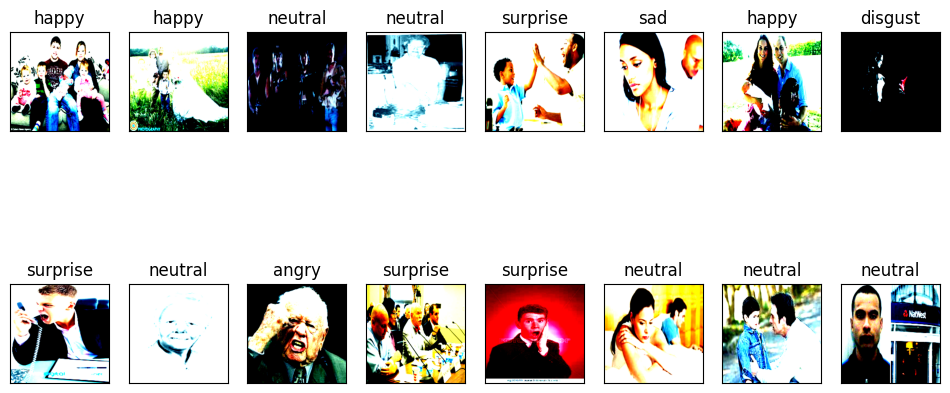

In [19]:
def show_batch(dl, class_labels):
  try:
    for images, label in dl:
        fig = plt.figure(figsize=(12, 6))
        for i in range(images.shape[0]):
          ax = fig.add_subplot(2, 8, i+1, xticks=[], yticks=[])
          ax.imshow(images[i].permute(1,2,0))
          ax.set_title(class_labels[label[i]])
        break
  except:
    print(label[i])

show_batch(train_loader, labels)

### Model Definition

In [20]:
# Load pretrained resnet50 (reference: https://pytorch.org/vision/main/models.html )
model_1 = resnet50(weights=ResNet50_Weights.DEFAULT).to(device) # original model
# # summary of the model
# summary(model_1, input_size=(3, 224, 224), depth = 3)
print (model_1) # to understand names and modules of the model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
# Freeze model parameters
for param in model_1.parameters():
    param.requires_grad = False

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = model_1.fc.in_features
model_1.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 7)
    # ,
    # nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [22]:
print(model_1) # checking if the FC layer has changed

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
len(labels)

7

In [24]:
# Freeze model parameters
for param in model_1.parameters():
    param.requires_grad = True

In [25]:
model_1.layer4[2].relu = nn.Identity()
model_1.layer4[2].bn3 = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)

In [26]:
print(model_1) # checking if the ReLU and BN in layer 4 has changed

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
!pip install torch-lr-finder
from torch_lr_finder import LRFinder

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [28]:
import copy
model_oclr = copy.deepcopy(model_1)
model_oclr = model_oclr.to(device)


# Define Optimizer and Loss Function
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9) # SGD is good for CV task #TODO : Try Adam

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.71E-03


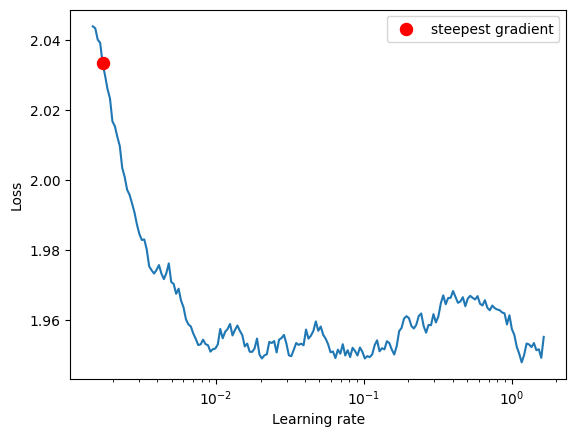

0.0017069989973731781


In [29]:
from torch_lr_finder import LRFinder
from tqdm.autonotebook import tqdm


lr_finder = LRFinder(model_oclr, optimizer, loss_func, device="cuda")
lr_finder.range_test(train_loader, end_lr=2, num_iter=200,step_mode = "exp")
_, best_lr = lr_finder.plot() # to inspect the loss-learning rate graph
print(best_lr)
lr_finder.reset() # to reset the model and optimizer to their initial state

In [30]:
model_1 = model_1.to(device)

In [31]:
max_lr = best_lr
EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9) # SGD is good for CV task #TODO : Try Adam
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=float(max_lr),
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS,
                                                pct_start=(5/EPOCHS),## how much percent of cycle to use for building up
                                                div_factor=100,## initial lr max/div_factor
                                                three_phase=False, ## no annihilation
                                                final_div_factor=100,## min lr max/div_factor
                                                anneal_strategy='linear'
                                                )

In [32]:
from tqdm import tqdm
import torch
import torch.nn as nn


def get_correct_predictions(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels).sum().item()


def train(model, device, train_loader, optimizer, criterion, scheduler=None):
    """
    Function to train model on the training dataset
    :param model: Model architecture
    :param device: Device on which training is to be done (GPU/CPU)
    :param train_loader: DataLoader for training dataset
    :param optimizer: Optimization algorithm to be used for updating weights
    :param criterion: Loss function for training
    :param scheduler: Scheduler for learning rate
    """
    # Enable layers like Dropout for model training
    model.train()

    # Utility to display training progress
    pbar = tqdm(train_loader)

    # Variables to track loss and accuracy during training
    train_loss = 0
    correct = 0
    processed = 0

    # Iterate over each batch and fetch images and labels from the batch
    for batch_idx, (data, target) in enumerate(pbar):

        # Put the images and labels on the selected device
        data, target = data.to(device), target.to(device)

        # Reset the gradients for each batch
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Use learning rate scheduler if defined
        if scheduler:
            scheduler.step()

        # Get total number of correct predictions
        correct += get_correct_predictions(pred, target)
        processed += len(data)

        # Display the training information
        pbar.set_description(
            desc=f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}')

    return correct, processed, train_loss


def test(model, device, test_loader, criterion):
    """
    Function to test the model training progress on the test dataset
    :param model: Model architecture
    :param device: Device on which training is to be done (GPU/CPU)
    :param test_loader: DataLoader for test dataset
    :param criterion: Loss function for test dataset
    """
    # Disable layers like Dropout for model inference
    model.eval()

    # Variables to track loss and accuracy
    test_loss = 0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, (data, target) in enumerate(test_loader):

            # Put the images and labels on the selected device
            data, target = data.to(device), target.to(device)

            # Pass the images to the output and get the model predictions
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_predictions(output, target)

    # Calculate test loss for a epoch
    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return correct, test_loss


def get_lr(optimizer):
    """
    Function to track learning rate while model training
    :param optimizer: Optimizer used for training
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [33]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
learning_rates = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [ ]:
# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model_1, device, train_loader, optimizer, criterion, scheduler)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))
    learning_rates.append(get_lr(optimizer))

    # Test the model's performance on test dataset and append the training loss and accuracy
    correct, test_loss = test(model_1, device, val_loader, criterion)
    test_acc.append(100. * correct / len(val_loader.dataset))
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.6002 Batch_id=3404 Accuracy=40.83: 100%|██████████| 3405/3405 [12:12<00:00,  4.65it/s]


Test set: Average loss: 0.0886, Accuracy: 6139/13620 (45.07%)

Epoch 2


Train: Loss=1.3362 Batch_id=3404 Accuracy=49.73: 100%|██████████| 3405/3405 [11:51<00:00,  4.78it/s]


Test set: Average loss: 0.0767, Accuracy: 7463/13620 (54.79%)

Epoch 3


Train: Loss=0.8930 Batch_id=3404 Accuracy=56.41: 100%|██████████| 3405/3405 [11:44<00:00,  4.84it/s]


Test set: Average loss: 0.0730, Accuracy: 7894/13620 (57.96%)

Epoch 4


Train: Loss=0.8556 Batch_id=3404 Accuracy=60.76: 100%|██████████| 3405/3405 [11:34<00:00,  4.90it/s]


Test set: Average loss: 0.0712, Accuracy: 8059/13620 (59.17%)

Epoch 5


Train: Loss=0.9877 Batch_id=3404 Accuracy=64.43: 100%|██████████| 3405/3405 [11:31<00:00,  4.92it/s]


Test set: Average loss: 0.0736, Accuracy: 8013/13620 (58.83%)

Epoch 6


Train: Loss=1.1413 Batch_id=3404 Accuracy=68.51: 100%|██████████| 3405/3405 [11:21<00:00,  5.00it/s]


Test set: Average loss: 0.0772, Accuracy: 7929/13620 (58.22%)

Epoch 7


Train: Loss=0.8378 Batch_id=3404 Accuracy=73.20: 100%|██████████| 3405/3405 [11:26<00:00,  4.96it/s]


Test set: Average loss: 0.0821, Accuracy: 7833/13620 (57.51%)

Epoch 8


Train: Loss=1.5279 Batch_id=3404 Accuracy=77.34: 100%|██████████| 3405/3405 [11:30<00:00,  4.93it/s]


Test set: Average loss: 0.0883, Accuracy: 7739/13620 (56.82%)

Epoch 9


Train: Loss=0.5912 Batch_id=3404 Accuracy=80.97: 100%|██████████| 3405/3405 [11:30<00:00,  4.93it/s]


Test set: Average loss: 0.0978, Accuracy: 7584/13620 (55.68%)

Epoch 10


Train: Loss=0.3042 Batch_id=3404 Accuracy=83.99: 100%|██████████| 3405/3405 [11:30<00:00,  4.93it/s]


Test set: Average loss: 0.1090, Accuracy: 7602/13620 (55.81%)

Epoch 11


Train: Loss=0.7254 Batch_id=3404 Accuracy=87.27: 100%|██████████| 3405/3405 [11:32<00:00,  4.92it/s]


Test set: Average loss: 0.1123, Accuracy: 7386/13620 (54.23%)

Epoch 12


Train: Loss=0.4783 Batch_id=3404 Accuracy=90.25: 100%|██████████| 3405/3405 [11:33<00:00,  4.91it/s]


Test set: Average loss: 0.1182, Accuracy: 7444/13620 (54.65%)

Epoch 13


Train: Loss=0.0389 Batch_id=3404 Accuracy=92.62: 100%|██████████| 3405/3405 [11:31<00:00,  4.92it/s]


Test set: Average loss: 0.1273, Accuracy: 7571/13620 (55.59%)

Epoch 14


Train: Loss=0.9093 Batch_id=3404 Accuracy=94.27: 100%|██████████| 3405/3405 [11:39<00:00,  4.87it/s]


Test set: Average loss: 0.1337, Accuracy: 7702/13620 (56.55%)

Epoch 15


Train: Loss=0.2053 Batch_id=3404 Accuracy=95.94: 100%|██████████| 3405/3405 [11:29<00:00,  4.94it/s]


Test set: Average loss: 0.1367, Accuracy: 7629/13620 (56.01%)

Epoch 16


Train: Loss=0.0196 Batch_id=3404 Accuracy=97.10: 100%|██████████| 3405/3405 [11:29<00:00,  4.94it/s]


Test set: Average loss: 0.1437, Accuracy: 7692/13620 (56.48%)

Epoch 17


Train: Loss=0.0135 Batch_id=121 Accuracy=98.00:   4%|▎         | 122/3405 [00:26<13:13,  4.14it/s]

## Checking training and results

In [ ]:
import seaborn as sns

def plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses):
    sns.set(font_scale=1)
    plt.rcParams["figure.figsize"] = (25,6)

    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(train_losses), 'b', label="Train Loss")

    # Label the plot.
    ax1.set_title("Train Loss")
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(np.array(train_accuracy), 'b', label="Train Accuracy")

    # Label the plot.
    ax2.set_title("Train Accuracy")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.show()

    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(test_losses), 'b', label="Test Loss")

    # Label the plot.
    ax1.set_title("Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(np.array(test_accuracy), 'b', label="Test Accuracy")

    # Label the plot.
    ax2.set_title("Test Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.show()

In [ ]:
plot_metrics(train_accuracy, [x.cpu().detach().numpy() for x in train_losses], test_accuracy, test_losses)


### Classwise accuracy

In [ ]:
def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
            	label = labels[i]
            	class_correct[label] += c[i].item()
            	class_total[label] += 1

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
evaluate_classwise_accuracy(model_1, device, labels, val_loader)

### Misclassified Images

In [ ]:
def plot_misclassified_images(wrong_predictions, mean, std, n_images=20, class_names=None):
    """
    Plot the misclassified images.
    """
    if class_names is None:
        class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    fig = plt.figure(figsize=(10, 12))
    fig.tight_layout()
    for i, (img, pred, correct) in enumerate(wrong_predictions[:n_images]):
        img, pred, target = img.cpu().numpy().astype(dtype=np.float32), pred.cpu(), correct.cpu()
        for j in range(img.shape[0]):
            img[j] = (img[j] * std[j]) + mean[j]

        img = np.transpose(img, (1, 2, 0))
        ax = fig.add_subplot(5, 5, i + 1)
        ax.axis("off")
        ax.set_title(f"\nactual : {class_names[target.item()]}\npredicted : {class_names[pred.item()]}", fontsize=10)
        ax.imshow(img)

    plt.show()

def misclassified_images(model, test_loader, device, mean, std, class_names=None, n_images=20):
    """
    Get misclassified images.
    """
    wrong_images = []
    wrong_label = []
    correct_label = []
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability

            wrong_pred = pred.eq(target.view_as(pred)) == False
            wrong_images.append(data[wrong_pred])
            wrong_label.append(pred[wrong_pred])
            correct_label.append(target.view_as(pred)[wrong_pred])

            wrong_predictions = list(zip(torch.cat(wrong_images), torch.cat(wrong_label), torch.cat(correct_label)))
        print(f"Total wrong predictions are {len(wrong_predictions)}")

        plot_misclassified_images(wrong_predictions, mean, std, n_images=n_images, class_names=class_names)

    return wrong_predictions



In [ ]:
images_misclassified = misclassified_images(model_1, val_loader, device, mean_ds, std_dev_ds , class_names=labels)